In [49]:
import os
os.chdir('D://scratch_backup//perl//jdftx_mod_test//denser_mesh//sicko_mode')
import numpy as np
import funcs as func
bandfile='water.bandProjections'
gvecfile='water.Gvectors'
eigfile='water.eigenvals'
proj, nStates, nBands, nProj, nSpecies, nOrbsPerAtom = func.parse_bandfile(bandfile)
wk, iGarr, k_points, nStates = func.parse_gvecfile(gvecfile)
E = func.parse_eigfile(eigfile, nStates)
header, data = func.parse_dos('water.dos')
def T_ijk(iorb, jband, kstate):
	return proj[kstate][jband][iorb]
def P_uvjk(uorb,vorb,jband, kstate):
	return np.conjugate(T_ijk(uorb, jband, kstate))*T_ijk(vorb, jband, kstate)
def e_jk(jband,kstate):
	return E[kstate][jband]
def H_uvk(uorb,vorb,kstate):
	sum_hold = 0
	for j in range(nBands):
		sum_hold += e_jk(j, kstate)*P_uvjk(uorb, vorb, j, kstate)
	return sum_hold
def pCOHP_uvk(uorb,vorb,kstate,Emin,Emax,dE):
	Huvk = H_uvk(uorb,vorb,kstate)
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for j in range(nBands):
		ejk = e_jk(j, kstate)
		if ((ejk < Emax) and (ejk > Emin)):
			e_idx = int(np.floor((ejk - Emin)/dE))
			e_weight = ejk - Egrid[e_idx]
			e_spill = Egrid[int(e_idx + 1)] - ejk
			x = P_uvjk(uorb, vorb, j, kstate) * Huvk
			output[e_idx] += np.real(x) * e_weight
			output[e_idx+1] += np.real(x) * e_spill
	return output, Egrid
def pCOHP_uv(uorb,vorb,Emin,Emax,dE):
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for k in range(nStates):
		output += pCOHP_uvk(uorb,vorb,k,Emin,Emax,dE)[0] * wk[k]
	return output, Egrid

In [50]:
def Hk_atomic_matrix(orb_idcs, k, array=False):
	dim = len(orb_idcs)
	out = []
	for i in range(dim):
		out.append([])
		for j in range(dim):
			out[-1].append(0)
	for i in range(dim):
		for j in range(dim):
			out[i][j] = H_uvk(orb_idcs[i],orb_idcs[j],k)
	if array:
		return np.array(out)
	else:
		return out

def H_atomic_matrices(orb_idcs, k_points, array=False, select=None):
	if select is None:
		select = range(len(k_points))
	out = []
	for k in select:
		out.append(Hk_atomic_matrix(orb_idcs, k, array=array))
	return out

def H_atomic_matrix(orb_idcs, select=None):
	matrices = H_atomic_matrices(orb_idcs, k_points, array=True, select=select)
	out = np.zeros(np.shape(matrices[0]), dtype=complex)
	for i in range(len(k_points)):
		out += matrices[i]*wk[i]
	return out
orbs = [0,1,2,3,4,5]
H_gamma_atomic = Hk_atomic_matrix(orbs, 0, array=True)
Hks_atomic = H_atomic_matrices(orbs, k_points, array=True)
H_atomic = H_atomic_matrix(orbs)

In [51]:
atomic_eigs = np.linalg.eig(H_atomic)

In [52]:
def eigs_to_xy_both(eig, x, y, dE = 0.01, height = 1):
	x.append(eig - dE*2)
	x.append(eig - dE)
	x.append(eig)
	x.append(eig + dE)
	x.append(eig + 2*dE)
	y.append(0)
	y.append(height)
	y.append(0)
	y.append(-height)
	y.append(0)
	return x, y

def eigs_to_xy_up(eig, x, y, dE = 0.01, height = 1):
	x.append(eig - dE)
	x.append(eig)
	x.append(eig + dE)
	y.append(0)
	y.append(height)
	y.append(0)

def eigs_to_xy(eig_vals, height=1, up=False, dE = 0.01):
	x = []
	y = []
	if not up:
		for eig in eig_vals:
			x, y = eigs_to_xy_both(eig, x, y, dE = dE, height = height)
	else:
		for eig in eig_vals:
			x, y = eigs_to_xy_up(eig, x, y)
	return x, y

In [53]:
x_atomic, y_atomic = eigs_to_xy(np.real(atomic_eigs[0]), height=50, dE=0.001)

In [54]:
def parse_dos(filename):
    header = None
    data = []
    for line in open(filename):
        if header is None:
            header = line.rstrip('\n').split('\t')
        else:
            data.append(line.rstrip('\n').split('\t'))
    return header, np.array(data, dtype=float).T

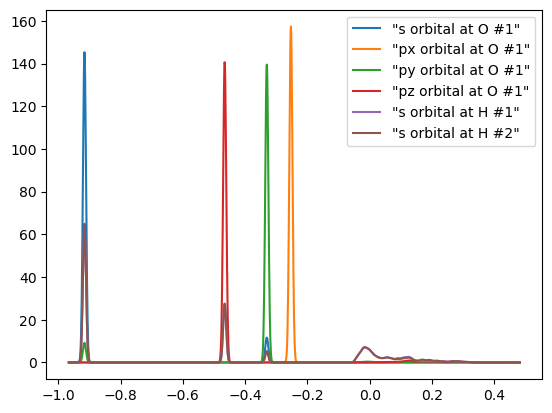

In [55]:
import matplotlib.pyplot as plt
for i, h in enumerate(header[1:]):
    plt.plot(data[0], data[i+1], label=h)
plt.legend()
xmin, xmax = plt.gca().get_xlim()

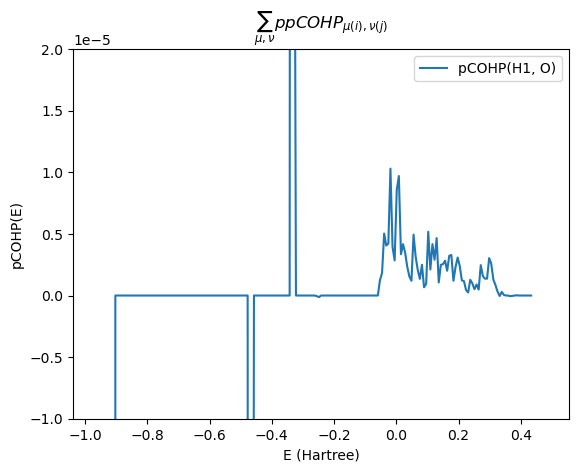

In [56]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]

plt.plot(Egrid, pCOHP_sum, label='pCOHP(H1, O)')
plt.xlim(xmin, xmax)
plt.ylim(-0.00001, 0.00002)
plt.title(r'$\sum_{\mu,\nu}ppCOHP_{\mu(i),\nu(j)}$')
plt.xlabel('E (Hartree)')
plt.ylabel('pCOHP(E)')
plt.legend()
plt.savefig('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//prelim_figs//' + 'ppCOHP_H1_O_zoom.png', bbox_inches='tight', facecolor='white')

In [57]:
gaussian_energies = [
	-0.93811, -0.49418, -0.32553, -0.26299, 0.00273, 0.09722, 0.15203
]
gaussian_plot_energies = []
gaussian_plot_ocs = []
dE = 0.001
occ_height = 50
for e in gaussian_energies:
	gaussian_plot_energies.append(e - 2*dE)
	gaussian_plot_energies.append(e - dE)
	gaussian_plot_energies.append(e + dE)
	gaussian_plot_energies.append(e + 2*dE)
	gaussian_plot_ocs.append(0)
	gaussian_plot_ocs.append(occ_height)
	gaussian_plot_ocs.append(-occ_height)
	gaussian_plot_ocs.append(0)

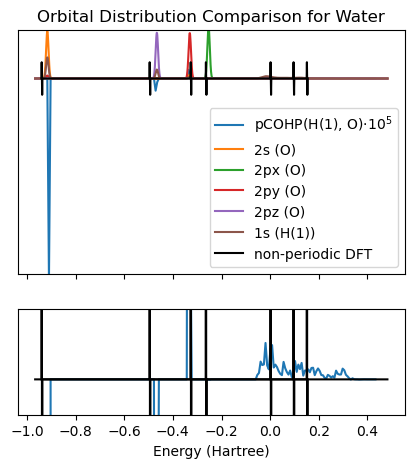

In [74]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(5, 5), gridspec_kw={'height_ratios': [2.3, 1]})
axes[0].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H(1), O)$\cdot10^5$')
axes[1].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
axes[1].set_ylim(-1, 2)
labels = [
	"2s (O)",
	"2px (O)",
	"2py (O)",
	"2pz (O)",
	"1s (H(1))"
]
for i, h in enumerate(header[1:-1]):
	axes[0].plot(data[0], data[i+1], label=labels[i])
#	axes[1].plot(data[0], data[i+1], label=labels[i])
axes[0].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
axes[1].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
axes[1].plot(data[0], np.zeros(len(data[0])), color='black')
plt.xlim(xmin, xmax)
axes[0].set_ylim(-600, 150)
axes[0].legend(loc='lower right')
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[0].set_title('Orbital Distribution Comparison for Water')
axes[1].set_xlabel('Energy (Hartree)')
plt.savefig('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//prelim_figs//' + 'pCOHP_and_pDOS_water_2.png')

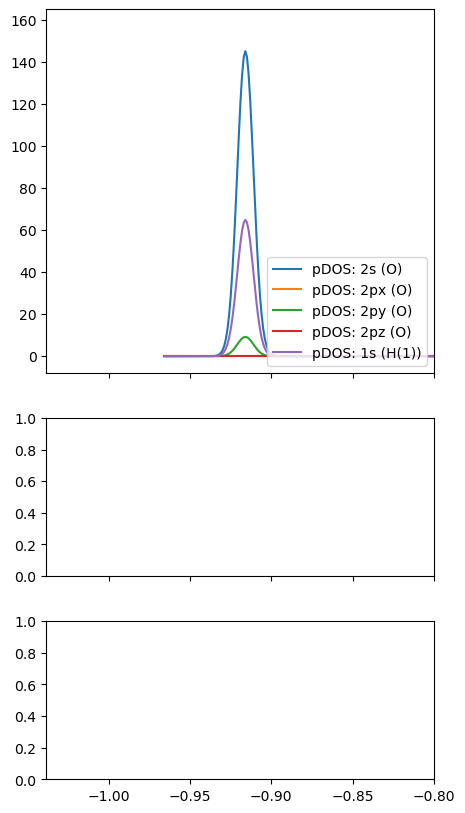

In [162]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(5, 10), gridspec_kw={'height_ratios': [2.3, 1, 1]})
# axes[0].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H(1), O)$\cdot10^5$')
# axes[1].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
# axes[2].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
# axes[1].set_ylim(-1, 100)
labels = [
	"pDOS: 2s (O)",
	"pDOS: 2px (O)",
	"pDOS: 2py (O)",
	"pDOS: 2pz (O)",
	"pDOS: 1s (H(1))"
]
# for i, h in enumerate(header[1:-1]):
# 	axes[0].plot(data[0], data[i+1], label=labels[i])
# 	axes[1].plot(data[0], data[i+1], label=labels[i])
# axes[0].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
# #axes[1].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
# axes[1].plot(data[0], np.zeros(len(data[0])), color='black')
# axes[2].plot(data[0], np.zeros(len(data[0])), color='black')
plt.xlim(xmin, -0.8)
# axes[0].set_ylim(-600, 150)
axes[0].plot(data[0], data[0+1], label=labels[0])
axes[0].plot(data[0], data[1+1], label=labels[1])
axes[0].plot(data[0], data[2+1], label=labels[2])
axes[0].plot(data[0], data[3+1], label=labels[3])
axes[0].plot(data[0], data[4+1], label=labels[4])
axes[0].legend(loc='lower right')
# axes[0].set_yticks([])
# axes[1].set_yticks([])
# axes[0].set_title('Orbital Distribution Comparison for Water')
# axes[1].set_xlabel('Energy (Hartree)')
#plt.savefig('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//prelim_figs//' + 'pCOHP_and_pDOS_water_4.png')

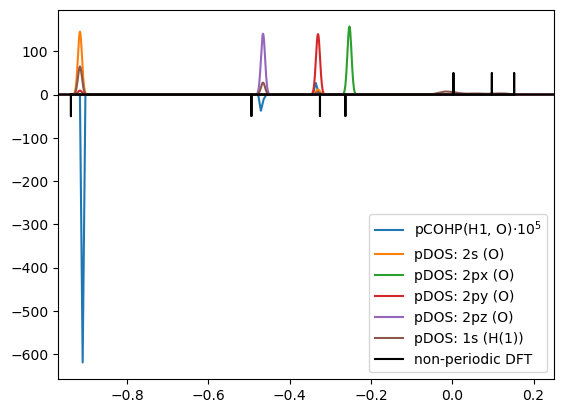

In [113]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
plt.plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
labels = [
	"pDOS: 2s (O)",
	"pDOS: 2px (O)",
	"pDOS: 2py (O)",
	"pDOS: 2pz (O)",
	"pDOS: 1s (H(1))"
]
for i, h in enumerate(header[1:-1]):
    plt.plot(data[0], data[i+1], label=labels[i])
plt.plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
plt.plot(data[0], np.zeros(len(data[0])), color='black')
plt.xlim(-0.97, 0.25)
plt.legend()
plt.savefig('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//prelim_figs//' + 'pCOHP_and_pDOS_water_3.png')

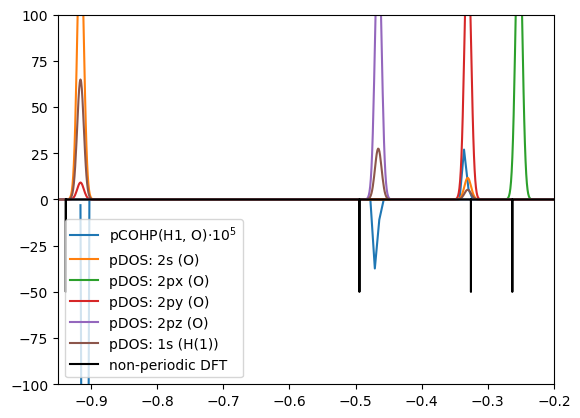

In [114]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
plt.plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
labels = [
	"pDOS: 2s (O)",
	"pDOS: 2px (O)",
	"pDOS: 2py (O)",
	"pDOS: 2pz (O)",
	"pDOS: 1s (H(1))"
]
for i, h in enumerate(header[1:-1]):
    plt.plot(data[0], data[i+1], label=labels[i])
plt.plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
plt.xlim(-0.95, -0.2)
plt.ylim(-100, 100)
plt.legend()
plt.savefig('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//prelim_figs//' + 'pCOHP_and_pDOS_water_5.png')

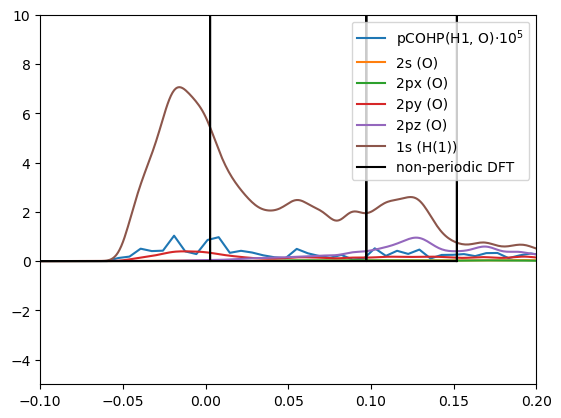

In [115]:

gaussian_energies = [
	-0.93811, -0.49418, -0.32553, -0.26299, 0.00273, 0.09722, 0.15203
]
gaussian_signs = [
	-1,        -1,         -1,       -1,        1,      1,      1
]
gaussian_plot_energies = []
gaussian_plot_ocs = []
dE = 0.00001
occ_height = 50
for i, e in enumerate(gaussian_energies):
	if abs(gaussian_signs[i]) > 0:
		gaussian_plot_energies.append(e - dE)
		gaussian_plot_energies.append(e)
		gaussian_plot_energies.append(e + dE)
		gaussian_plot_ocs.append(0)
		gaussian_plot_ocs.append(occ_height*gaussian_signs[i])
		gaussian_plot_ocs.append(0)
	else:
		gaussian_plot_energies.append(e - 2*dE)
		gaussian_plot_energies.append(e - dE)
		gaussian_plot_energies.append(e)
		gaussian_plot_energies.append(e + dE)
		gaussian_plot_energies.append(e + 2*dE)
		gaussian_plot_ocs.append(0)
		gaussian_plot_ocs.append(occ_height)
		gaussian_plot_ocs.append(0)
		gaussian_plot_ocs.append(-1*occ_height)
		gaussian_plot_ocs.append(0)
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
plt.plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
labels = [
	"2s (O)",
	"2px (O)",
	"2py (O)",
	"2pz (O)",
	"1s (H(1))"
]
for i, h in enumerate(header[1:-1]):
    plt.plot(data[0], data[i+1], label=labels[i])
plt.plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
plt.xlim(-0.1, 0.2)
plt.ylim(-5, 10)
plt.legend()
plt.savefig('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//prelim_figs//' + 'pCOHP_and_pDOS_water_6.png')

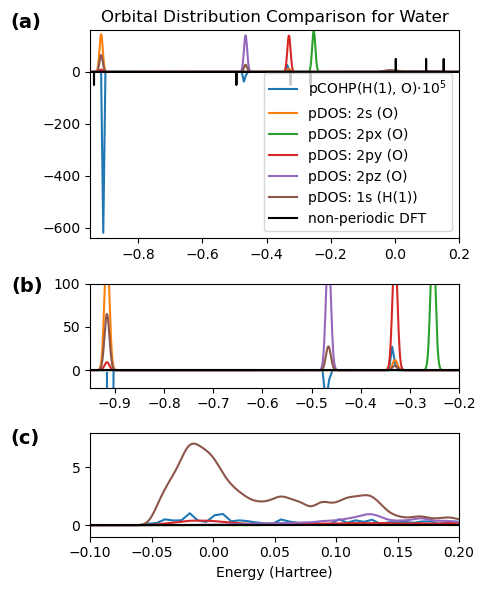

In [164]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
fig, axes = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(5, 6), gridspec_kw={'height_ratios': [2, 1, 1]})
axes[0].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H(1), O)$\cdot10^5$')
axes[1].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
axes[2].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
labels = [
	"pDOS: 2s (O)",
	"pDOS: 2px (O)",
	"pDOS: 2py (O)",
	"pDOS: 2pz (O)",
	"pDOS: 1s (H(1))"
]
for i, h in enumerate(header[1:-1]):
	axes[0].plot(data[0], data[i+1], label=labels[i])
	axes[1].plot(data[0], data[i+1], label=labels[i])
	axes[2].plot(data[0], data[i+1], label=labels[i])
axes[0].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
#axes[1].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
axes[0].plot(data[0], np.zeros(len(data[0])), color='black')
axes[1].plot(data[0], np.zeros(len(data[0])), color='black')
axes[2].plot(data[0], np.zeros(len(data[0])), color='black')
axes[0].set_xlim(-0.95, 0.2)
axes[0].set_ylim(-640, 160)
axes[1].set_ylim(-20, 100)
axes[1].set_xlim(-0.95, -0.2)
axes[2].set_xlim(-0.1, 0.2)
axes[2].set_ylim(-1, 8)
axes[0].legend(loc='lower right')
axes[0].set_title('Orbital Distribution Comparison for Water')
axes[2].set_xlabel('Energy (Hartree)')
axes[0].text(-1.2, 170, '(a)', fontsize=14, fontweight='bold')
axes[1].text(-1.11, 90, '(b)', fontsize=14, fontweight='bold')
axes[2].text(-0.165, 7, '(c)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//prelim_figs//' + 'pCOHP_and_pDOS_water_4.png')

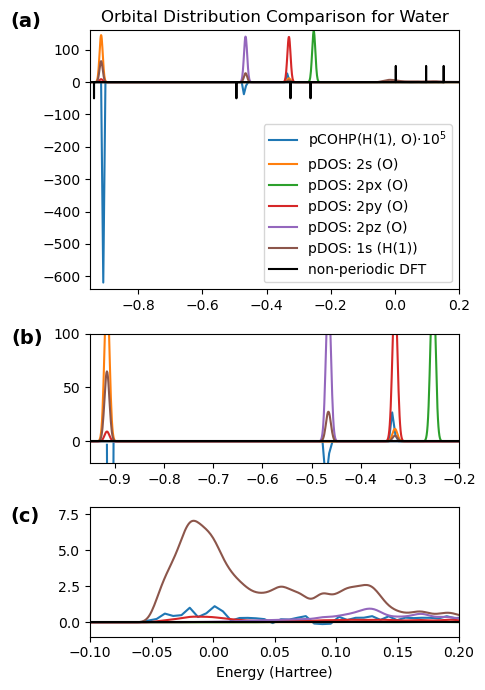

In [163]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [1]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
fig, axes = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(5, 7), gridspec_kw={'height_ratios': [2, 1, 1]})
axes[0].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H(1), O)$\cdot10^5$')
axes[1].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
axes[2].plot(Egrid, pCOHP_sum*(10**5), label=r'pCOHP(H1, O)$\cdot10^5$')
labels = [
	"pDOS: 2s (O)",
	"pDOS: 2px (O)",
	"pDOS: 2py (O)",
	"pDOS: 2pz (O)",
	"pDOS: 1s (H(1))"
]
for i, h in enumerate(header[1:-1]):
	axes[0].plot(data[0], data[i+1], label=labels[i])
	axes[1].plot(data[0], data[i+1], label=labels[i])
	axes[2].plot(data[0], data[i+1], label=labels[i])
axes[0].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
#axes[1].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
axes[0].plot(data[0], np.zeros(len(data[0])), color='black')
axes[1].plot(data[0], np.zeros(len(data[0])), color='black')
axes[2].plot(data[0], np.zeros(len(data[0])), color='black')
axes[0].set_xlim(-0.95, 0.2)
axes[0].set_ylim(-640, 160)
axes[1].set_ylim(-20, 100)
axes[1].set_xlim(-0.95, -0.2)
axes[2].set_xlim(-0.1, 0.2)
axes[2].set_ylim(-1, 8)
axes[0].legend(loc='lower right')
axes[0].set_title('Orbital Distribution Comparison for Water')
axes[2].set_xlabel('Energy (Hartree)')
axes[0].text(-1.2, 170, '(a)', fontsize=14, fontweight='bold')
axes[1].text(-1.11, 90, '(b)', fontsize=14, fontweight='bold')
axes[2].text(-0.165, 7, '(c)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//prelim_figs//' + 'pCOHP_and_pDOS_water_switch.png')

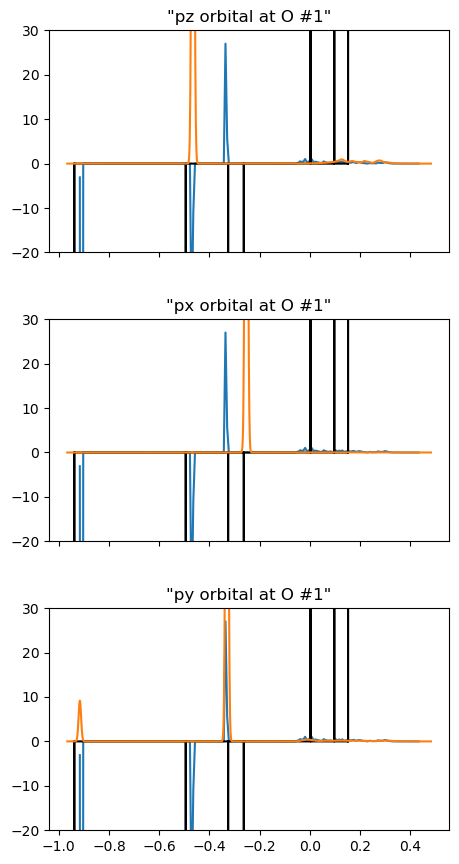

In [116]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
nsubplots = len(header) - 1
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(5, 10))
for n in range(1, 4):
	axes[n-3].plot(Egrid, pCOHP_sum*(10**5), label='pCOHP(H1, O)*10^5')
	axes[n-3].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
	axes[n-3].plot(data[0], data[n + 1], label=header[n+1])
	axes[n-3].set_ylim(-20, 30)
	#axes[n-3].set_xlim(-0.4, -0.2)
	# axes[n].legend()
	axes[n-3].set_title(header[n+1])

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.3)
plt.savefig('water_comparison3_by_pDOS.png')
# plt.plot(Egrid, pCOHP_sum*(10**5), label='pCOHP(H1, O)*10^5')
# for i, h in enumerate(header[1:-1]):
#     plt.plot(data[0], data[i+1], label=h)
# plt.plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='black')
# plt.legend()

(-1.0, 0.3)

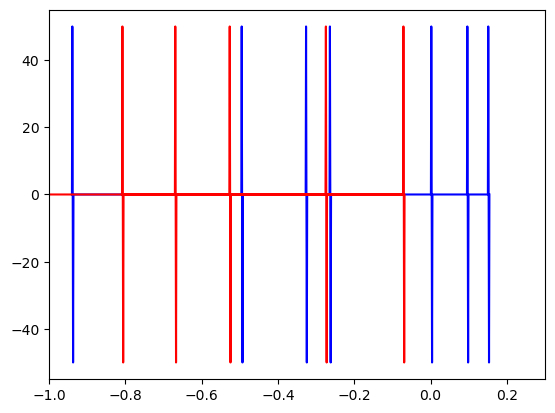

In [61]:
plt.plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT', color='blue')
plt.plot(x_atomic, y_atomic, label='diagonalized atomic energies', color='red')
plt.xlim(-1,0.3)

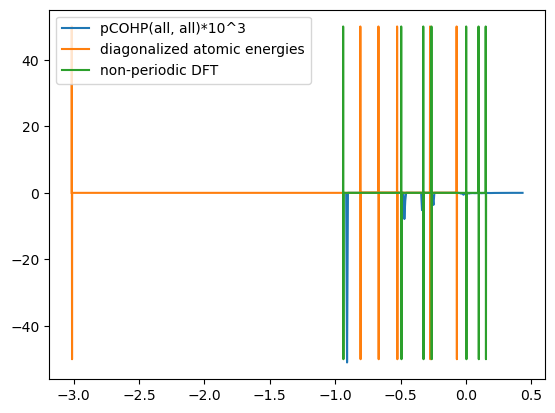

In [62]:
orb_idcs = [0,1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in orb_idcs:
	for v in orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
plt.plot(Egrid, pCOHP_sum*(10**3), label='pCOHP(all, all)*10^3')
plt.plot(x_atomic, y_atomic, label='diagonalized atomic energies')
plt.plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT')
plt.legend()

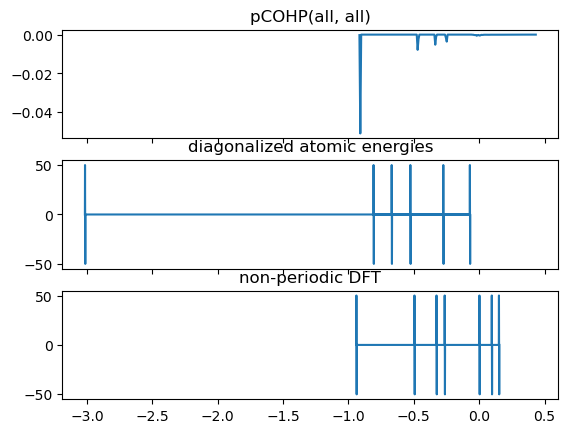

In [63]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
axes[0].plot(Egrid, pCOHP_sum, label='pCOHP(all, all)*10^3')
axes[0].set_title('pCOHP(all, all)')
axes[1].plot(x_atomic, y_atomic, label='diagonalized atomic energies')
axes[1].set_title('diagonalized atomic energies')
axes[2].plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT')
axes[2].set_title('non-periodic DFT')
plt.savefig('allatomic_pCOHP_diag_gaussian_compare.png')

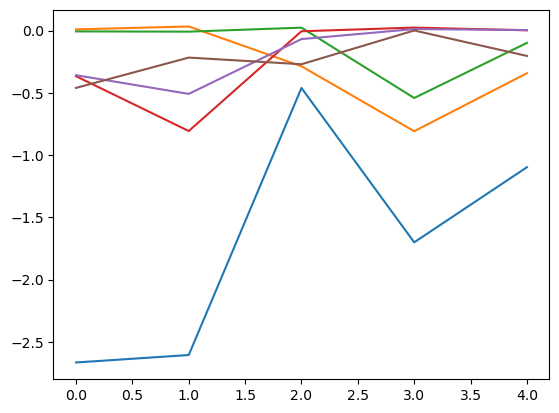

In [29]:
orbs = [0,1,2,3,4,5]
gamma_x_idcs = [0,1,2,3,4]
band_eigvals = []
for orb in orbs:
	band_eigvals.append([])
for idx in gamma_x_idcs:
	matrix = Hk_atomic_matrix(orbs, idx, array=True)
	eig_vals = np.real(np.linalg.eigvals(matrix))
	for i, val in enumerate(eig_vals):
		band_eigvals[i].append(val)
for band in band_eigvals:
	plt.plot(gamma_x_idcs, band)

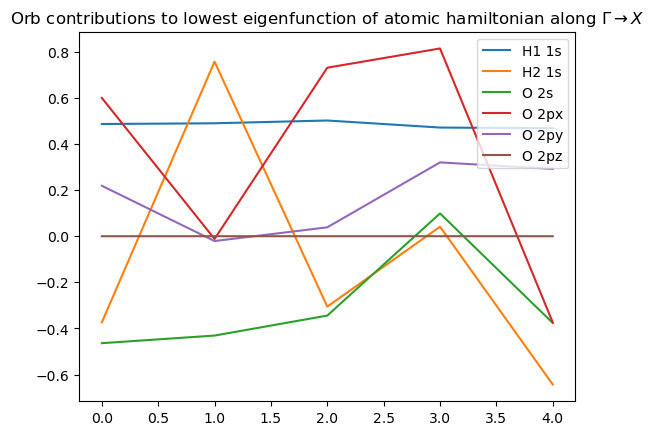

In [37]:
orbs = [0,1,2,3,4,5]
gamma_x_idcs = [0,1,2,3,4]
band_eigvals = []
band_eigvals_im_component = []
orb_fractions = []
for orb in orbs:
	band_eigvals.append([])
	orb_fractions.append([])
	band_eigvals_im_component.append([])
for idx in gamma_x_idcs:
	matrix = Hk_atomic_matrix(orbs, idx, array=True)
	eig_vals, eig_vecs = np.linalg.eig(matrix)
	for i, val in enumerate(eig_vals):
		band_eigvals[i].append(np.real(val))
		band_eigvals_im_component[i].append(np.imag(val))
		orb_fractions[i].append(eig_vecs[i])
orb_fractions = np.array(orb_fractions)
labels = ['H1 1s', 'H2 1s', 'O 2s', 'O 2px', 'O 2py', 'O 2pz']
for i, orb in enumerate(labels):
	plt.plot(gamma_x_idcs, np.real(orb_fractions[0,:,i]), label=orb)
plt.legend()
plt.title(r'Orb contributions to lowest eigenfunction of atomic hamiltonian along $\Gamma \rightarrow X$')
plt.savefig('orb_occs_eig0_gamma_to_X.png')

In [33]:
np.shape(orb_fractions)

(6, 5, 6)